<a href="https://colab.research.google.com/github/Zuhair0000/fine_tuning_course/blob/main/fine_tuning_BERT_for_multi_class_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/refs/heads/master/twitter_multi_class_sentiment.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        16000 non-null  object
 1   label       16000 non-null  int64 
 2   label_name  16000 non-null  object
dtypes: int64(1), object(2)
memory usage: 375.1+ KB


In [3]:
df.isnull().sum()

,0
text,0
label,0
label_name,0


In [4]:
df.describe()

,label
count,16000.000000
mean,1.565937
std,1.501430
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,5.000000


In [5]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Frequency of classes')

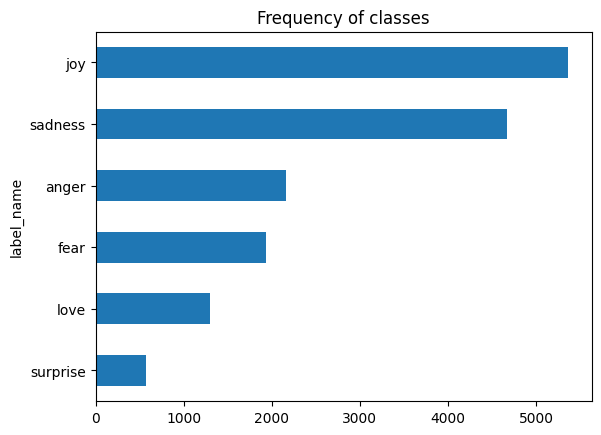

In [6]:
label_counts = df['label_name'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of classes")

<Axes: title={'center': 'words per tweet'}, xlabel='label_name'>

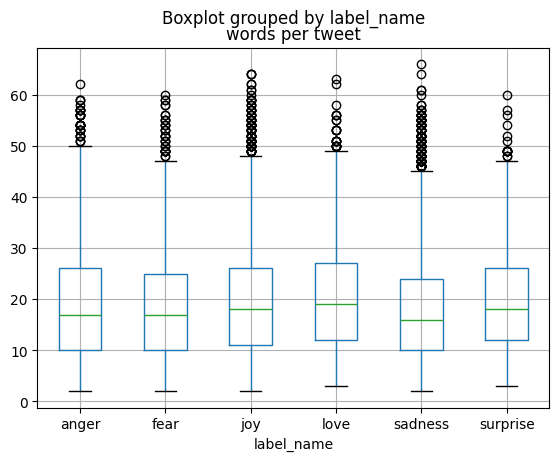

In [7]:
df['words per tweet'] = df['text'].str.split().apply(len)
df.boxplot('words per tweet', by='label_name')

In [8]:
df.head()

,text,label,label_name,words per tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4


In [9]:
from transformers import AutoTokenizer

model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

text = 'I love machine learning! Tokenizatoin is awesome'

encode_text = tokenizer(text)
print((encode_text))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

{'input_ids': [101, 1045, 2293, 3698, 4083, 999, 19204, 21335, 3406, 2378, 2003, 12476, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [10]:
tokenizer.vocab_size

30522

# Data Loader and Train Test Split

In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, stratify=df['label_name'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['label_name'])

train.shape, test.shape, validation.shape

((11200, 4), (3200, 4), (1600, 4))

# **Converting to Hugging Face Format**
Pandas is great for humans, but Hugging Face models prefer their own Dataset object format because it's faster for training.


1. Dataset.from_pandas: Converts the Pandas DataFrame into a Hugging Face Dataset.

2. preserve_index=False: Pandas creates a numbered index (0, 1, 2...) on the left. We don't need this extra column cluttering our AI data, so we throw it away.

3. DatasetDict: A container that holds all three splits (train, test, validation) in one variable, making it easy to access them later (e.g., dataset['train']).



In [12]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict(
    {'train': Dataset.from_pandas(train, preserve_index=False),
     'test': Dataset.from_pandas(test, preserve_index=False),
     'validation': Dataset.from_pandas(validation, preserve_index=False)
     }
)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'words per tweet'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'words per tweet'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'words per tweet'],
        num_rows: 1600
    })
})

In [13]:
dataset['train'][0]

{'text': 'im feeling really good about it',
 'label': 1,
 'label_name': 'joy',
 'words per tweet': 6}

# Tokenization

In [14]:
def tokenize(batch):
  temp = tokenizer(batch['text'], padding=True, truncation=True)
  return temp

print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 10047, 3110, 2428, 2204, 2055, 2009, 102], [101, 1045, 2123, 1056, 2514, 2008, 15752, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1]]}


In [15]:
emotion_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/11200 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [16]:
emotion_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'words per tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'words per tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'words per tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1600
    })
})

In [17]:
label2id = {x['label_name']:x['label'] for x in dataset['train']}
id2label = {v:k for k, v in label2id.items()}

label2id, id2label

({'joy': 1, 'love': 2, 'sadness': 0, 'fear': 4, 'surprise': 5, 'anger': 3},
 {1: 'joy', 2: 'love', 0: 'sadness', 4: 'fear', 5: 'surprise', 3: 'anger'})

In [18]:
from transformers import AutoModel
import torch

In [19]:
model = AutoModel.from_pretrained(model_ckpt)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [20]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [21]:
from transformers import AutoModelForSequenceClassification, AutoConfig

num_labels = len(label2id)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [22]:
device

device(type='cuda')

In [23]:
from transformers import TrainingArguments

batch_size = 64
training_dir = 'bert_base_train_dir'
training_args = TrainingArguments(output_dir = training_dir,
                                  # overwrite_output_dir = True,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay = 0.01,
                                  eval_strategy = 'epoch',
                                  disable_tqdm = False
                                  )



In [24]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.6 MB/s eta 0:00:00


In [25]:
import evaluate
import numpy as np

accuracy = evaluate.load('accuracy')

def compute_metrics_evaluate(eval_pred):
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return accuracy.compute(predictions=predictions, reference=labels)



In [26]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  f1 = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)

  return{
      'accuracy': acc,
      "f1": f1
  }

# Build Model and Trainer

In [27]:
from transformers import Trainer, DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotion_encoded['train'],
                  eval_dataset=emotion_encoded['validation'],
                  data_collator=data_collator
                  )

In [28]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.426363,0.869375,0.859147
2,No log,0.262285,0.920625,0.920700


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=350, training_loss=0.6647692435128348, metrics={'train_runtime': 365.784, 'train_samples_per_second': 61.238, 'train_steps_per_second': 0.957, 'total_flos': 1001502421516800.0, 'train_loss': 0.6647692435128348, 'epoch': 2.0})

# Model Evaluation

In [29]:
preds_output = trainer.predict(emotion_encoded['test'])
preds_output.metrics

{'test_loss': 0.2712216377258301,
 'test_accuracy': 0.915,
 'test_f1': 0.9143154131700248,
 'test_runtime': 15.8223,
 'test_samples_per_second': 202.246,
 'test_steps_per_second': 3.16}

In [34]:
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = emotion_encoded['test'][:]['label']

In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       933
           1       0.94      0.94      0.94      1072
           2       0.83      0.78      0.80       261
           3       0.89      0.92      0.90       432
           4       0.89      0.88      0.89       387
           5       0.87      0.74      0.80       115

    accuracy                           0.92      3200
   macro avg       0.89      0.87      0.88      3200
weighted avg       0.91      0.92      0.91      3200



In [36]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

<Axes: >

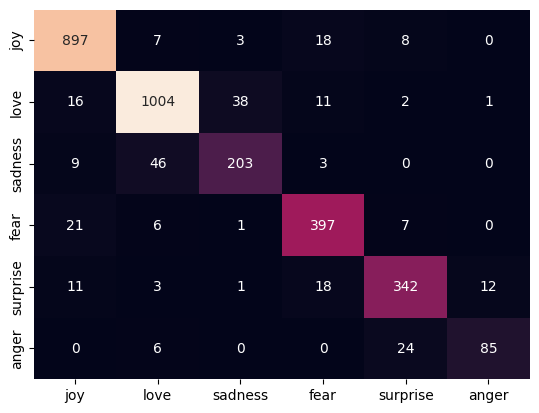

In [39]:
cm = confusion_matrix(y_true, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt='d', cbar=False)